In [1]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#from google.colab import drive 
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
# Download images and choose a style image and a content image
content_path_1 = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path_2   = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)  
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (422, 512))

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

(1, 422, 512, 3)
(1, 422, 512, 3)


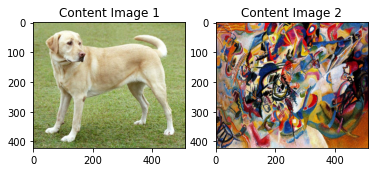

In [6]:
content_image_1 = load_img(content_path_1)
content_image_2 = load_img(content_path_2)

print(content_image_1.shape)
print(content_image_2.shape)

plt.subplot(1, 2, 1)
imshow(content_image_1, 'Content Image 1')

plt.subplot(1, 2, 2)
imshow(content_image_2, 'Content Image 2')

In [7]:
# Creates a vgg model that returns a list of intermediate output values
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [8]:
# create the model:
content_layers_1 = ['block5_conv2']
content_layers_2 = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1']

num_content_layers_1 = len(content_layers_1)
num_content_layers_2 = len(content_layers_2)

content_2_extractor = vgg_layers(content_layers_2)
content_2_outputs   = content_2_extractor(content_image_2*255)

# Look at the statistics of each layer's output
for name, output in zip(content_layers_2, content_2_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

80142336/80134624 [==============================] - 1s 0us/step
block1_conv1
  shape:  (1, 422, 512, 64)
  min:  0.0
  max:  835.3745
  mean:  33.517567

block2_conv1
  shape:  (1, 211, 256, 128)
  min:  0.0
  max:  4684.2173
  mean:  195.22046

block3_conv1
  shape:  (1, 105, 128, 256)
  min:  0.0
  max:  8639.883
  mean:  224.08011

block4_conv1
  shape:  (1, 52, 64, 512)
  min:  0.0
  max:  21415.107
  mean:  758.9281

block5_conv1
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  3455.9849
  mean:  56.00708



In [14]:
class ContentModel(tf.keras.models.Model):
    def __init__(self, content_layers_2, content_layers_1):
        super(ContentModel, self).__init__()
        self.vgg = vgg_layers(content_layers_2 + content_layers_1)
        self.content_layers_2 = content_layers_2
        self.content_layers_1 = content_layers_1
        self.num_content_layers_2 = len(content_layers_2)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        content_2_outputs, content_1_outputs = (outputs[:self.num_content_layers_2],
                                          outputs[self.num_content_layers_2:])

        content_1_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers_1, content_1_outputs)}

        content_2_dict = {content_2_name: value
                      for content_2_name, value
                      in zip(self.content_layers_2, content_2_outputs)}

        return {'content_1': content_1_dict, 'content_2': content_2_dict}

In [16]:
extractor = ContentModel(content_layers_2, content_layers_1)
results = extractor(tf.constant(content_image_1))

print('content_2:')
for name, output in sorted(results['content_2'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content_1'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

content_2:
   block1_conv1
    shape:  (1, 422, 512, 64)
    min:  0.0
    max:  550.1154
    mean:  15.226082

   block2_conv1
    shape:  (1, 211, 256, 128)
    min:  0.0
    max:  3191.6501
    mean:  89.55595

   block3_conv1
    shape:  (1, 105, 128, 256)
    min:  0.0
    max:  4486.9497
    mean:  81.42939

   block4_conv1
    shape:  (1, 52, 64, 512)
    min:  0.0
    max:  13530.511
    mean:  351.3847

   block5_conv1
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  4270.3394
    mean:  33.99466

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


In [17]:
content_2_targets = extractor(content_image_2)['content_1']
content_1_targets = extractor(content_image_1)['content_1']

In [18]:
print(content_image_1.shape)
image = tf.Variable(tf.random.uniform(content_image_1.shape, minval=0, maxval=1))
print(image.shape)
print(image[0].numpy().shape)

(1, 422, 512, 3)
(1, 422, 512, 3)
(422, 512, 3)


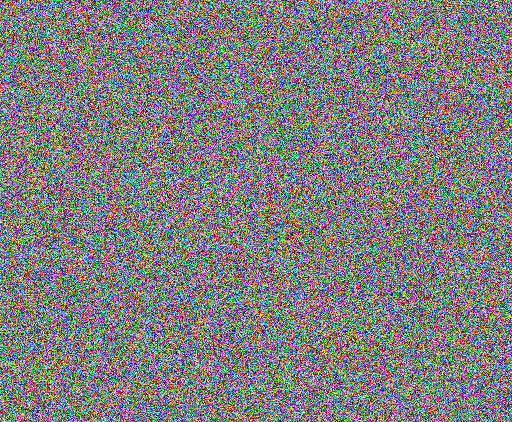

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

display.display(tensor_to_image(image))

fname = 'two_content_loss/at_%d.png' % 0
mpl.image.imsave(fname, image[0].numpy())

In [28]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

content_2_weight   = 1e4
content_weight = 1e4

def content_loss(outputs):
    content_outputs = outputs['content_1']

    content_2_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_2_targets[name])**2) 
                           for name in content_outputs.keys()])
    content_2_loss *= content_2_weight / num_content_layers_2

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_1_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers_1
    
    loss = content_2_loss + content_loss
    return loss

In [29]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

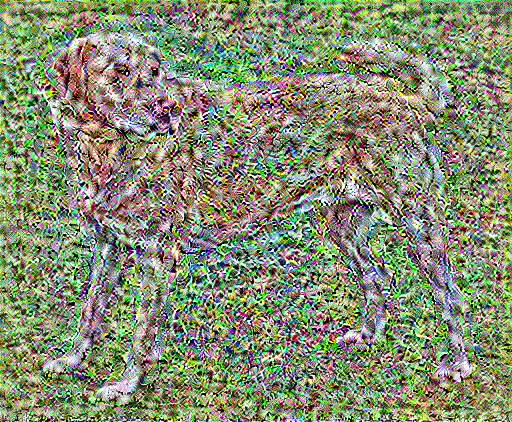

Train step: 300
Total time: 19.6


In [31]:
import time
start = time.time()

epochs = 1
steps_per_epoch = 300

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

    fname = 'two_content_loss/at_%d.png' % (n+1)
    mpl.image.imsave(fname, image[0].numpy())
    
end = time.time()
print("Total time: {:.1f}".format(end-start))